In [173]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [174]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [175]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [176]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")


In [177]:
# declare a Base using 'automap_base'
Base = automap_base()

In [178]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [179]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [180]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [181]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [182]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))      

[(62.0, 69.57142857142857, 74.0)]


In [183]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
query = (calc_temps('2016-08-01','2017-08-01'))
query


[(58.0, 74.64288840262581, 87.0)]

<ErrorbarContainer object of 3 artists>

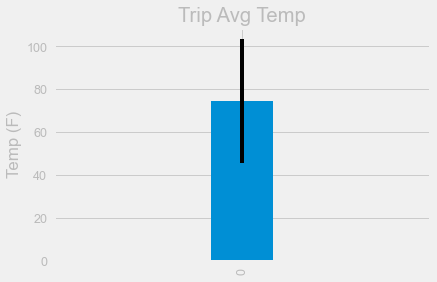

In [184]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame(query, columns=['min', 'avg', 'max'])
df['avg'].plot.bar(title = 'Trip Avg Temp', width = 0.1)
plt.ylabel('Temp (F)')
plt.errorbar(0,df['avg'],yerr=df['max']-df['min'],ecolor='black')

### Daily Rainfall Average

In [244]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
mea = session.query(Measurement.station, Measurement.prcp).filter(Measurement.date.between('2016-08-01','2017-08-01')).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()    
mea

[('USC00519281', 3.53),
 ('USC00513117', 2.35),
 ('USC00516128', 2.21),
 ('USC00519523', 0.54),
 ('USC00519397', 0.08),
 ('USC00517948', 0.0),
 ('USC00514830', None)]

In [252]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
same_station = session.query(Measurement.station, Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation).filter(Measurement.station==Station.station).filter(Measurement.date.between('2016-08-01','2017-08-01')).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
same_station

[('USC00519281',
  3.53,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 2.35, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00516128',
  2.21,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519523',
  0.54,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 0.08, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', 0.0, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00514830',
  None,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0)]

In [256]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [395]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
index_name = ['2017-08-01','2017-08-02','2017-08-03','2017-08-04','2017-08-05','2017-08-06','2017-08-07']

# Strip off the year and save a list of strings in the format %m-%d



# Use the `daily_normals` function to calculate the normals for each date string and append the results to a list called `normals`.
day1 = daily_normals('08-01')
day2 = daily_normals('08-02')
day3 = daily_normals('08-03')
day4 = daily_normals('08-04')
day5 = daily_normals('08-05')
day6 = daily_normals('08-06')
day7 = daily_normals('08-07')

day1.extend(day2)
day1.extend(day3)
day1.extend(day4)
day1.extend(day5)
day1.extend(day6)
day1.extend(day7)

day1

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [399]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(day1, columns=['min','avg','max'])
df['date'] = index_name
df.set_index('date')

,min,avg,max
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


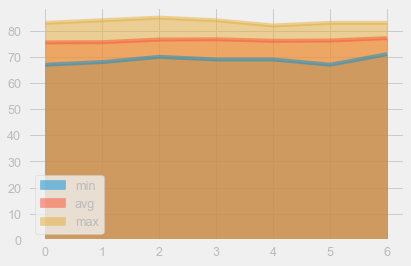

In [403]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)

## Close Session

In [401]:
session.close ()
